In [129]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from fbprophet import Prophet
import statsmodels.tsa.stattools as tsa # Time series analysis

pd.plotting.register_matplotlib_converters()
sns.set()

# Loading Data and Preprocessing

In [164]:
df = pd.read_csv("atlanta_data.csv")
df["DATE"] = pd.to_datetime(df["DATE"], format="%Y-%m-%d")

# Set the index to the date
# df.set_index("DATE", inplace=True, drop=False)

# Calculate the average temperature
t_avg = lambda row: (row["TMIN"] + row["TMAX"]) / 2
f_to_c = lambda row: float(((row["TAVG"] - 32) * 5 / 9))

df["TAVG"] = df.apply(t_avg, axis=1)
df = df[["TAVG", "DATE"]]
df = df.dropna()

df["TAVG"] = (df["TAVG"] - 32) * 5 / 9

print("Null values:")
df.isnull().sum()

Null values:


TAVG    0
DATE    0
dtype: int64

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32871 entries, 0 to 32877
Data columns (total 2 columns):
TAVG    32871 non-null float64
DATE    32871 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 770.4 KB


# Data Visualization

Text(0, 0.5, 'Average Temperature (C)')

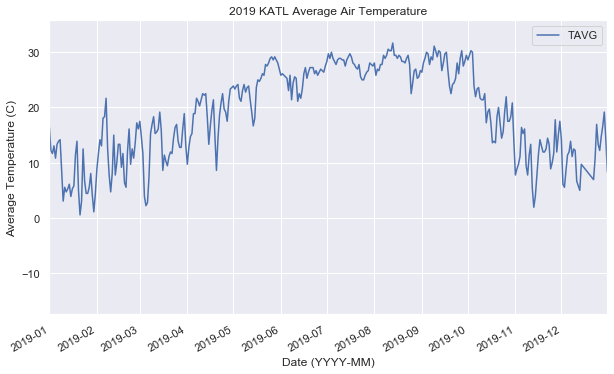

In [132]:
ax1 = df.plot(x="DATE", y="TAVG", figsize=(10,6))
ax1.set_xlim(pd.Timestamp("2019-01-01"), pd.Timestamp("2019-12-31"))
ax1.set_title("2019 KATL Average Air Temperature")
ax1.set_xlabel("Date (YYYY-MM)")
ax1.set_ylabel("Average Temperature (C)")

There are four components to time series,
1. Trend: Long time pattern (increase / decrease) of the series.
2. Seasonality: Repeating cycles. For example, increase of temperatures every year during the summer months.
3. Cyclical: Up down patterns of the series.
4. Noise: Random variation.

In [146]:
def plot_yearly_avg(df):
    g = df.groupby(df["DATE"].dt.year)["TAVG"].mean()
    g = g.drop(g.tail(1).index) # We only keep data up to 2019 since 2020 data is imcomplete

    ax2 = g.plot(figsize=(10, 6))
    ax2.set_title("Yearly Average Air Temperature at KATL")
    ax2.set_xlabel("Year")
    ax2.set_ylabel("Temperature (C)")

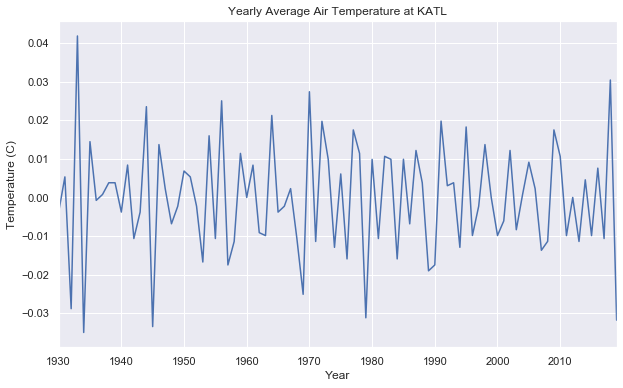

In [147]:
plot_yearly_avg(df)

Interesting

# Stationary Assumption for Time Series Models
Most time series (TS) models require that the data be stationary to work well. When a dataset is stationary, its statistical quantities are constant over the time period of the data. For example, the mean, variance, and autocovariance are constant.

We want our data to be stationary so our model can accurately predict data at *all* points of interest.


Let's take a look at our yearly average data again...

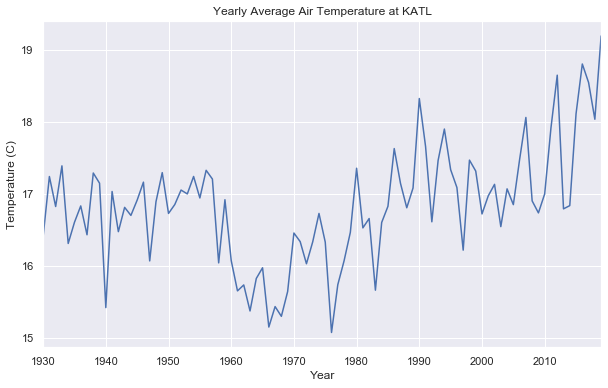

In [135]:
plot_yearly_avg()

This plot shows trend and seasonal effects on the data. Statistics are not consistent over time. There is also a trend change at around 1960.

In [136]:
def print_stats(df):
    df_cpy = df.copy()
    df_cpy["DATE"] = df_cpy["DATE"].values.astype(float)
    X = df_cpy.values
    split = len(X) // 2
    X1, X2 = X[0: split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print("Mean: X1 = {}, X2 = {}".format(mean1, mean2))
    print("Variance: X1 = {}, X2 = {}".format(var1, var2))
    
print_stats(df)

Mean: X1 = -2.7614567905080618e+17, X2 = 4.338795127768314e+17
Variance: X1 = 1.602830442607813e+35, X2 = 2.722768727309457e+35


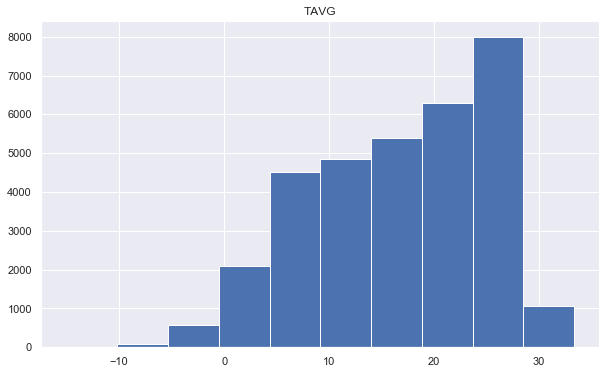

In [137]:
def plot_dist(df):
    df_cpy = df.copy()
    df_cpy[["DATE", "TAVG"]].set_index("DATE").hist(figsize=(10, 6))
    
plot_dist(df)

Our histogram shows a **truncated normal distribution**. This is another sign of non stationary data. We can also run an Augmented Dickey-Fuller Test to determine if our data has a unit root. The presence of a unit root indicates a stochastic, or random trend in the data. This means non-stationary data!

In [138]:
def print_adfuller(df):
    df = df.copy()
    print("Dickey-Fuller Test")
    results = tsa.adfuller(df["TAVG"])
    print("df (test Statistic) = {}".format(results[0]))
    print("pvalue = {}".format(results[1]))
    print("lags = {}".format(results[2]))
    print("nobs = {}".format(results[3]))

    for key, value in results[4].items():
        print("{} = {}".format(key, value))
    
print_adfuller(df)

Dickey-Fuller Test
df (test Statistic) = -15.695048869571698
pvalue = 1.4184890941268057e-28
lags = 52
nobs = 32818
1% = -3.4305492751405127
5% = -2.8616280745033746
10% = -2.566816879322118


Our test statistic is much greater than our critical values (absolute), therefore this series is non stationary based on the Dickey-Fuller test.

In [139]:
def print_kpss(df):
    df = df.copy()
    print("KPSS Test")
    results = tsa.kpss(df["TAVG"], regression="c")
    print("df (test Statistic) = {}".format(results[0]))
    print("pvalue = {}".format(results[1]))
    print("lags = {}".format(results[2]))

    for key, value in results[3].items():
        print("{} = {}".format(key, value))
print_kpss(df)

KPSS Test
df (test Statistic) = 0.19810054459913776
pvalue = 0.1
lags = 52
10% = 0.347
5% = 0.463
2.5% = 0.574
1% = 0.739


/Users/nigelhuang/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


The KPSS test concludes that our series is stationary. Since the KPSS test for stationary is positive and the DF test is negative, it means we have a trend stationary.

## Removing the trend

### Differencing
Removes the mean

               TAVG
count  3.286400e+04
mean   1.445351e-03
std    6.964187e+01
min   -4.097222e+02
25%   -3.888889e+01
50%   -2.398082e-14
75%    3.833333e+01
max    3.600000e+02


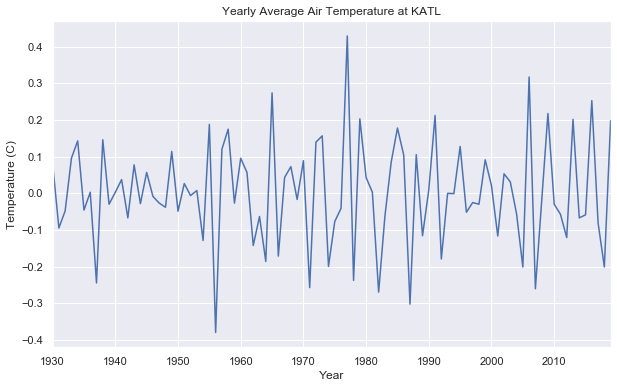

In [158]:
print(df.describe())
plot_yearly_avg(df)

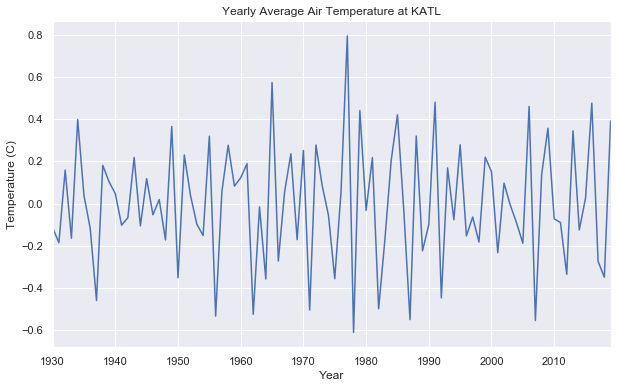

In [159]:
df["TAVG"] = df["TAVG"] - df["TAVG"].shift(1)
df = df.dropna()
plot_yearly_avg(df)

In [155]:
print_adfuller(df)

Dickey-Fuller Test
df (test Statistic) = -86.41527014933997
pvalue = 0.0
lags = 52
nobs = 32812
1% = -3.430549311582802
5% = -2.8616280906093916
10% = -2.5668168878949444


The pvalue is now approximately 0.0

In [165]:
# Model
# The fb prophet model requires the X and y columns to be named ds and y, respectively

df = df.rename(columns={"DATE": "ds", "TAVG": "y"})

model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [166]:
# Try to make some future + overlapping predictions to see how our model fits
future_df = model.make_future_dataframe(periods=365) # +1 year of data!

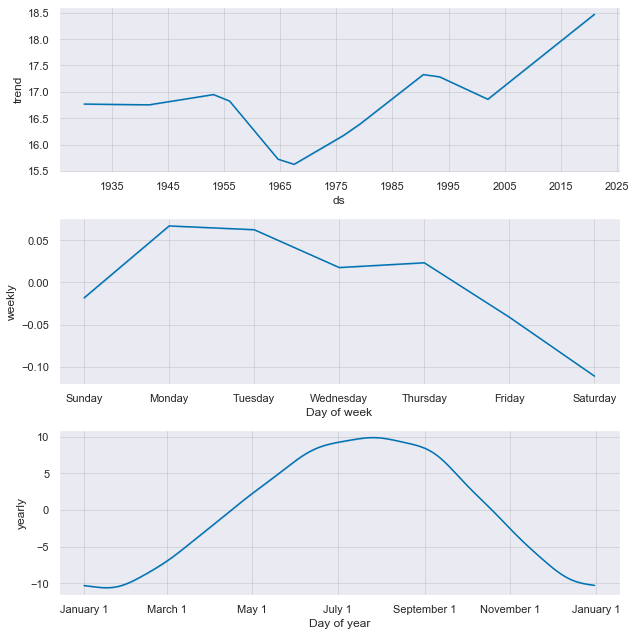

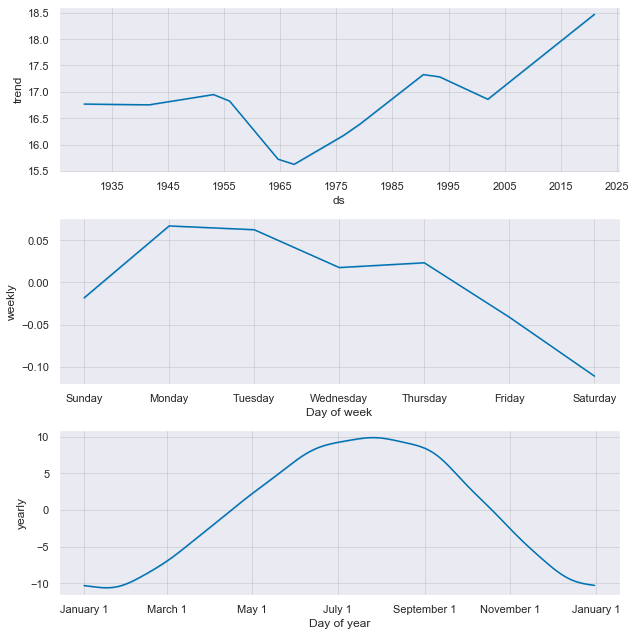

In [170]:
prediction = model.predict(future_df)
model.plot_components(prediction)

Text(0.5, 1.0, 'Temperature Predictions for 2020-2021')

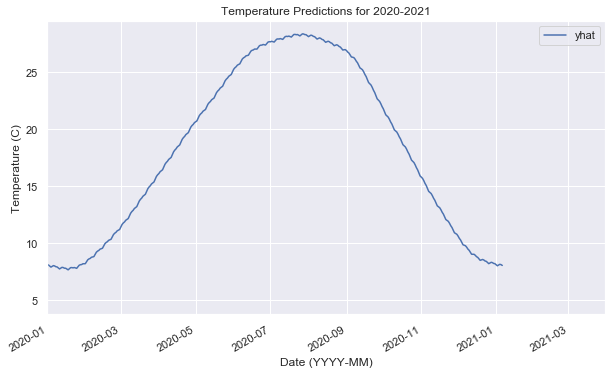

In [184]:
ax6 = prediction.plot(x="ds", y="yhat", figsize=(10, 6))
ax6.set_xlim(pd.Timestamp("2020-01-01"), pd.Timestamp("2021-03-31"))
ax6.set_xlabel("Date (YYYY-MM)")
ax6.set_ylabel("Temperature (C)")
ax6.set_title("Temperature Predictions for 2020-2021")